<h1>Reliance Stock Prices Prediction Model

<h2>Install and Import Dependencies

In [189]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

In [190]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<h2>Download Historical Stock Data from Yahoo Finance


In [191]:
ticker = "RELIANCE.NS"
start_date = "2010-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

In [192]:
# Download daily stock data
data = yf.download(ticker, start=start_date, end=end_date)
data = data.asfreq('B').ffill()  # Convert to business-day frequency, forward-fill missing

[*********************100%***********************]  1 of 1 completed


In [193]:
# Basic exploration
print("Data Head:")
print(data.head())
print("\nData Info:")
print(data.info())
print("\nData Description:")
print(data.describe())

Data Head:
Price            Close        High         Low        Open      Volume
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                                  
2010-01-04  209.254379  212.289594  198.815993  212.289594  76646086.0
2010-01-05  208.320480  223.730024  207.289291  223.730024  21392825.0
2010-01-06  211.686432  212.951106  208.310726  210.110451  23691760.0
2010-01-07  215.198380  216.939737  209.740837  211.686494  26197920.0
2010-01-08  214.634155  216.706276  213.243018  215.577794  15110149.0

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3945 entries, 2010-01-04 to 2025-02-14
Freq: B
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Close, RELIANCE.NS)   3945 non-null   float64
 1   (High, RELIANCE.NS)    3945 non-null   float64
 2   (Low, RELIANCE.NS)     3945 non-null   float64
 3   (Open, RELIA

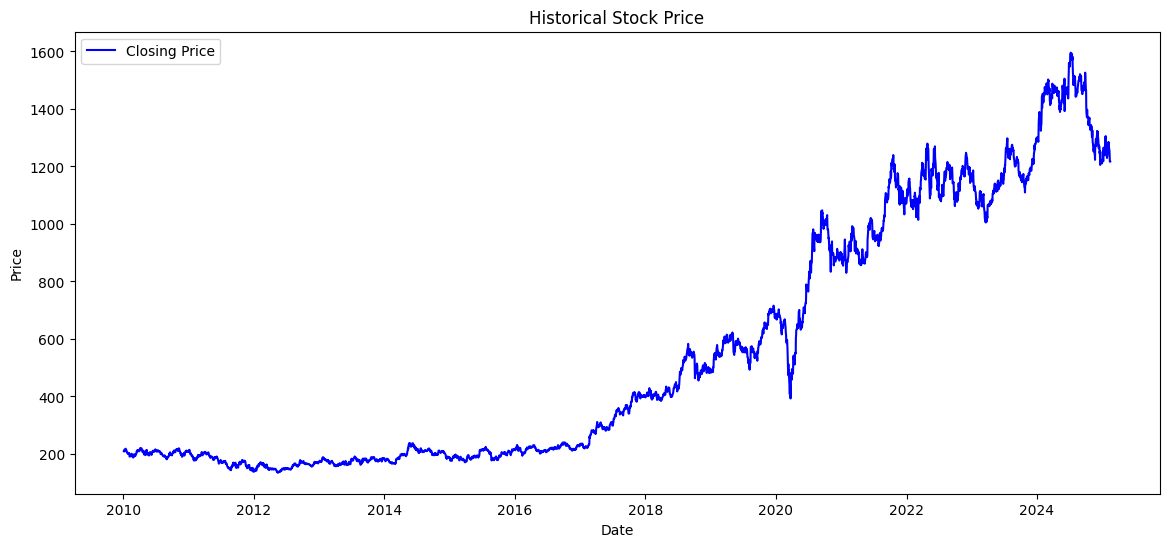

In [194]:
# Plot raw closing price
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.title('Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [195]:
print(f"Data from {data.index[0].date()} to {data.index[-1].date()}")
print(f"Total trading days: {len(data)}")

Data from 2010-01-04 to 2025-02-14
Total trading days: 3945


<h2>Feature Engineering & Data Preparation

In [196]:
# 1. Basic Feature Engineering
data['50_MA'] = data['Close'].rolling(50).mean()   # 50-day moving average
data['200_MA'] = data['Close'].rolling(200).mean() # 200-day moving average
data['Daily_Return'] = data['Close'].pct_change()  # % change from previous day

In [197]:
# 2. Include Volume as an additional feature (assuming your data has 'Volume' column)
#    If your ticker doesn't provide volume data, you can skip this line or handle missing data.
data['Volume'] = data['Volume'].fillna(0)  # Fill NaNs if any

# Drop rows with NaNs created by rolling/pct_change
data.dropna(inplace=True)

In [198]:
# 3. Data Scaling
# We'll scale 'Close', 'Volume', '50_MA', '200_MA', 'Daily_Return'
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['Close', 'Volume', '50_MA', '200_MA', 'Daily_Return']])

In [199]:
# 4. Create Sequences (60 timesteps to predict next day's Close)
SEQ_LENGTH = 60

def create_sequences(dataset, seq_length):
    X_list, y_list = [], []
    for i in range(len(dataset) - seq_length):
        X_list.append(dataset[i : i + seq_length])
        # Next day's close price (column index 0 in 'scaled_data')
        y_list.append(dataset[i + seq_length, 0])
    return np.array(X_list), np.array(y_list)

X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [200]:
# 5. Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Data shape after feature engineering: {scaled_data.shape}")
print(f"Sequence training data shape: {X_train.shape}, {y_train.shape}")
print(f"Sequence testing data shape: {X_test.shape}, {y_test.shape}")

Data shape after feature engineering: (3746, 5)
Sequence training data shape: (2948, 60, 5), (2948,)
Sequence testing data shape: (738, 60, 5), (738,)


<h2>LSTM Model Building

In [201]:
def build_lstm_model(input_shape):
    model = Sequential()
    # First LSTM layer with L2 regularization
    model.add(LSTM(
        128, return_sequences=True, 
        kernel_regularizer=l2(0.0005),  # small L2 penalty
        input_shape=input_shape
    ))
    model.add(Dropout(0.3))
    
    # Second LSTM layer with L2 regularization
    model.add(LSTM(
        64, return_sequences=False, 
        kernel_regularizer=l2(0.0005)
    ))
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(Dense(1))  # Final output: predicted close price
    
    # Compile model
    model.compile(optimizer='adam', loss='mse')
    return model

In [202]:
lstm_model = build_lstm_model((SEQ_LENGTH, X_train.shape[2]))
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 128)           68608     
                                                                 
 dropout_12 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 120,129
Trainable params: 120,129
Non-tr

<h2>Model Training & Evaluation

In [203]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ReduceLROnPlateau: reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=2, 
    min_lr=1e-6,
    verbose=1
)

# ModelCheckpoint: save the best model (lowest val_loss)
checkpoint = ModelCheckpoint(
    'best_lstm_model.h5', 
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

In [204]:
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
91/93 [============================>.] - ETA: 0s - loss: 0.0687
Epoch 1: val_loss improved from inf to 0.03519, saving model to best_lstm_model.h5
93/93 [==============================] - 4s 20ms/step - loss: 0.0683 - val_loss: 0.0352 - lr: 0.0010
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 0.0249
Epoch 2: val_loss improved from 0.03519 to 0.01795, saving model to best_lstm_model.h5
93/93 [==============================] - 1s 15ms/step - loss: 0.0249 - val_loss: 0.0179 - lr: 0.0010
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 0.0140
Epoch 3: val_loss improved from 0.01795 to 0.01261, saving model to best_lstm_model.h5
93/93 [==============================] - 1s 16ms/step - loss: 0.0140 - val_loss: 0.0126 - lr: 0.0010
Epoch 4/50
92/93 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 4: val_loss improved from 0.01261 to 0.00780, saving model to best_lstm_model.h5
93/93 [==============================] - 1s 15ms/step

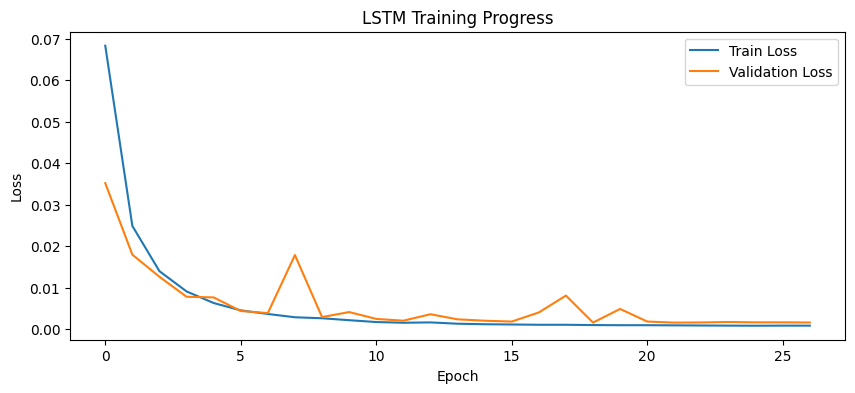

In [205]:
# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h2>Single-Step Prediction and Performance

In [206]:
# 1. Make predictions
train_pred = lstm_model.predict(X_train)
test_pred = lstm_model.predict(X_test)

24/24 [==============================] - 0s 6ms/step


In [207]:
# 2. Inverse-transform predictions back to original scale
def inverse_transform(preds):
    dummy = np.zeros((len(preds), scaled_data.shape[1]))
    dummy[:,0] = preds.flatten()  # place predictions in 'Close' column
    inv_data = scaler.inverse_transform(dummy)
    return inv_data[:,0]  # return just the close price column

train_pred_inv = inverse_transform(train_pred)
test_pred_inv = inverse_transform(test_pred)

In [208]:
# 3. Inverse-transform the actual y values
y_train_inv = inverse_transform(y_train.reshape(-1,1))
y_test_inv  = inverse_transform(y_test.reshape(-1,1))

In [209]:
# 4. Evaluation
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
train_mae  = mean_absolute_error(y_train_inv, train_pred_inv)
test_rmse  = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
test_mae   = mean_absolute_error(y_test_inv, test_pred_inv)

print(f"Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}")
print(f"Test  RMSE: {test_rmse:.2f}, Test  MAE: {test_mae:.2f}")

Train RMSE: 28.10, Train MAE: 20.44
Test  RMSE: 49.85, Test  MAE: 39.46


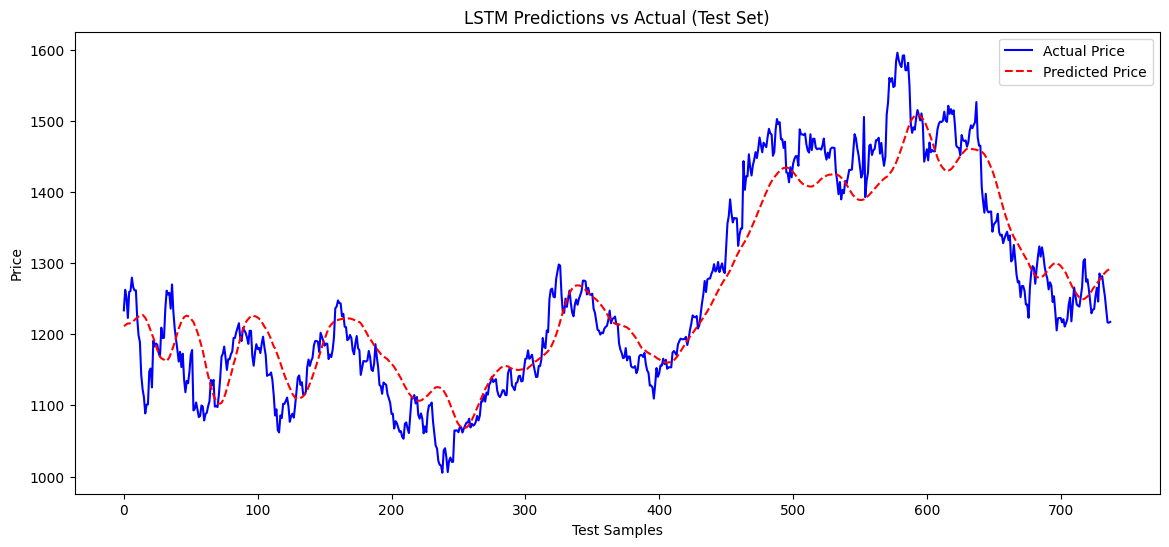

In [210]:
# 5. Plot actual vs. predicted on the test set
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(test_pred_inv, label='Predicted Price', color='red', linestyle='--')
plt.title('LSTM Predictions vs Actual (Test Set)')
plt.xlabel('Test Samples')
plt.ylabel('Price')
plt.legend()
plt.show()

<h2>Multi-Step (7-Day) Forecast

In [211]:
# 1. Get the last 60 days of scaled data
last_sequence = scaled_data[-SEQ_LENGTH:].copy()

future_predictions = []

In [212]:
# 2. Predict day by day for 7 days
num_days_to_forecast = 7
temp_sequence = last_sequence.reshape(1, SEQ_LENGTH, -1)

def inverse_transform_single_value(val):
    """Helper to inverse-transform a single predicted close price."""
    dummy = np.zeros((1, scaled_data.shape[1]))
    dummy[0, 0] = val
    return scaler.inverse_transform(dummy)[0,0]

for day in range(num_days_to_forecast):
    # Predict next day
    pred_scaled = lstm_model.predict(temp_sequence)
    
    # Inverse transform to get actual price
    pred_actual = inverse_transform_single_value(pred_scaled[0,0])
    future_predictions.append(pred_actual)
    
    # Prepare next input
    # We'll re-scale the newly predicted close price
    new_close_scaled = pred_scaled[0,0]
    
    # Optionally replicate the last known features for Volume, MAs, etc. 
    # (For a truly accurate approach, you'd re-compute them.)
    new_features = temp_sequence[0, -1, 1:]  # volume, 50_MA, 200_MA, daily_return from last step
    
    # Shift sequence left by 1
    temp_sequence = np.roll(temp_sequence, -1, axis=1)
    
    # Insert new row at the end
    temp_sequence[0, -1, 0] = new_close_scaled  # predicted close
    temp_sequence[0, -1, 1:] = new_features     # replicate old features or update them if you can

1/1 [==============================] - 0s 21ms/step


In [213]:
# 3. Print the next 7-day forecasts
print("Next 7-Day Forecast Prices:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: {price:.2f}")

Next 7-Day Forecast Prices:
Day 1: 1290.12
Day 2: 1288.67
Day 3: 1287.12
Day 4: 1285.73
Day 5: 1284.86
Day 6: 1283.13
Day 7: 1281.56
